### Imports

In [1]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero, LightGCN

import matplotlib.pyplot as plt

import pathlib
import os
import sys
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))
from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.visualize import plot_loss, plot_test

### Data

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title", "original_title"],
    list_features=[],
    fastRP_features=[],
    numeric_features=[],
    node2vec_features=[],
    SAGE_features=[],
)

data = dataset[0].to(device)
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

KeyboardInterrupt: 

### Model

In [ ]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)
        self.conv3 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index).relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv3(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, hidden_channels)
        self.lin4 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = F.dropout(z, p=0.1, training=self.training)
        z = self.lin2(z).relu()
        z = F.dropout(z, p=0.1, training=self.training)
        z = self.lin3(z).relu()
        z = F.dropout(z, p=0.1, training=self.training)
        z = self.lin4(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

### Train-test functions

In [ ]:
def train_test(model, use_weighted_loss, epochs=50):
    latest_predictions = []

    if use_weighted_loss:
        weight = torch.bincount(train_data['user', 'movie'].edge_label)
        weight = weight.max() / weight
    else:
        weight = None

    def weighted_mse_loss(pred, target, weight=None):
        weight = 1. if weight is None else weight[target].to(pred.dtype)
        return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


    def train():
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                    train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)


    @torch.no_grad()
    def test(data):
        nonlocal latest_predictions
        model.eval()
        pred = model(data.x_dict, data.edge_index_dict,
                    data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        latest_predictions = pred
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)

    for epoch in range(1, epochs):
        loss = train()
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data)
        if not epoch % 5:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
                f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    
    return latest_predictions


### Experiments on imbalanced DB with 100K ratings with <u>weighted and unweighted loss</u>

Epoch: 005, Loss: 9.3604, Train: 1.1775, Val: 1.1760, Test: 1.1917
Epoch: 010, Loss: 8.6180, Train: 2.0962, Val: 2.1097, Test: 2.1055
Epoch: 015, Loss: 7.5645, Train: 1.2644, Val: 1.2971, Test: 1.2847
Epoch: 020, Loss: 7.0147, Train: 1.7045, Val: 1.7247, Test: 1.7191
Epoch: 025, Loss: 6.6965, Train: 1.2724, Val: 1.2909, Test: 1.2891
Epoch: 030, Loss: 6.4243, Train: 1.5545, Val: 1.5724, Test: 1.5676
Epoch: 035, Loss: 6.1799, Train: 1.3015, Val: 1.3154, Test: 1.3053
Epoch: 040, Loss: 5.9311, Train: 1.3802, Val: 1.4144, Test: 1.4084
Epoch: 045, Loss: 5.5448, Train: 1.3412, Val: 1.3606, Test: 1.3683
Epoch: 050, Loss: 5.2747, Train: 1.2234, Val: 1.2348, Test: 1.2491
Epoch: 055, Loss: 4.6912, Train: 1.2330, Val: 1.2414, Test: 1.2432
Epoch: 060, Loss: 4.3588, Train: 1.3015, Val: 1.3274, Test: 1.3441
Epoch: 065, Loss: 4.2987, Train: 1.2846, Val: 1.3112, Test: 1.3157
Epoch: 070, Loss: 4.0389, Train: 1.2296, Val: 1.2547, Test: 1.2499
Epoch: 075, Loss: 3.9744, Train: 1.2028, Val: 1.2426, Test: 1.

(array([ 133.,  407.,  308.,  582., 1539., 2206., 2204., 2008.,  584.,
           9.]),
 array([0.12957017, 0.61661315, 1.10365617, 1.59069908, 2.0777421 ,
        2.564785  , 3.05182815, 3.53887105, 4.02591419, 4.5129571 ,
        5.        ]),
 <BarContainer object of 10 artists>)

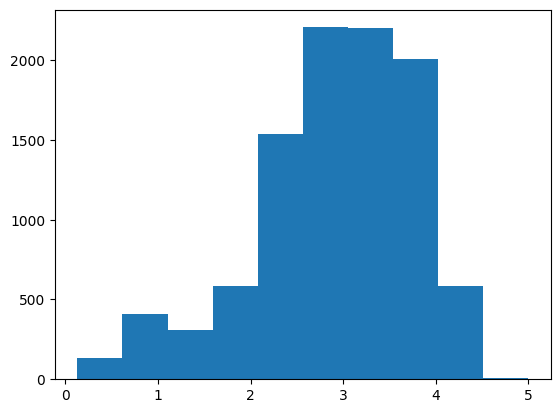

In [ ]:
model = Model(hidden_channels=32).to(device)
preds = train_test(model, use_weighted_loss=True, epochs=251)
plt.hist(preds)

Epoch: 005, Loss: 7.4245, Train: 1.5936, Val: 1.6245, Test: 1.6027
Epoch: 010, Loss: 3.5028, Train: 2.0942, Val: 2.1120, Test: 2.1120
Epoch: 015, Loss: 2.7184, Train: 1.2226, Val: 1.2329, Test: 1.2454
Epoch: 020, Loss: 1.9306, Train: 1.1136, Val: 1.1361, Test: 1.1273
Epoch: 025, Loss: 2.1779, Train: 1.2802, Val: 1.3116, Test: 1.2989
Epoch: 030, Loss: 1.9150, Train: 1.1015, Val: 1.1069, Test: 1.0985
Epoch: 035, Loss: 1.7239, Train: 1.1632, Val: 1.1901, Test: 1.1697
Epoch: 040, Loss: 1.5834, Train: 1.0810, Val: 1.0857, Test: 1.0858
Epoch: 045, Loss: 1.5340, Train: 1.1024, Val: 1.1191, Test: 1.1093
Epoch: 050, Loss: 1.4751, Train: 1.0792, Val: 1.0939, Test: 1.0889
Epoch: 055, Loss: 1.4157, Train: 1.0710, Val: 1.0877, Test: 1.0796
Epoch: 060, Loss: 1.3894, Train: 1.0971, Val: 1.1185, Test: 1.1098
Epoch: 065, Loss: 1.3680, Train: 1.0659, Val: 1.0793, Test: 1.0659
Epoch: 070, Loss: 1.3441, Train: 1.0588, Val: 1.0822, Test: 1.0820
Epoch: 075, Loss: 1.3185, Train: 1.0706, Val: 1.0892, Test: 1.

(array([  87.,  359., 1029., 2050., 2662., 2127., 1152.,  413.,   94.,
           7.]),
 array([1.57086921, 1.89743888, 2.22400856, 2.55057836, 2.87714815,
        3.20371771, 3.5302875 , 3.8568573 , 4.18342686, 4.50999689,
        4.83656645]),
 <BarContainer object of 10 artists>)

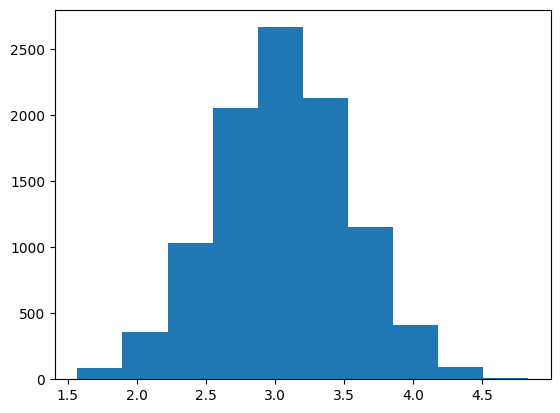

In [ ]:
model = Model(hidden_channels=32).to(device)
preds = train_test(model, use_weighted_loss=False, epochs=251)
plt.hist(preds)